# GET dT/dY for a TR case. 

In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must include .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
data_folder = "/Volumes/ThermalAmp/TR1-4/"

#from cmcrameri import cm

In [2]:
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]

In [3]:
# Define constants
tw = 308
yw = -0.015

# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
data_files = [f for f in data_files if "/._" not in f]

def get_time(data_file):
    return float(data_file.split(".")[0].split("-")[-1])  #My directories
    #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    #return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)
print(len(data_files))

15000


In [4]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


def get_mean_contour(node_x, node_y, mean_SI):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """
    
    from scipy.interpolate import griddata
    SI = griddata((node_x, node_y), mean_SI, (xgrid, ygrid), method='nearest', fill_value=np.nan)
    return SI


def get_T(node_x, node_y, data_file):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """

    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        #U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        #V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        
        return flowtime, timestep, T


In [5]:
timestep = 7000
fname = os.path.join(data_folder, data_files[timestep])
_,_,Tvals = get_T(node_x, node_y, data_file=fname)

In [6]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning
        
# Use LokyBackend tso protect the h5py routine
SIs = Parallel(n_jobs=-1, backend='threading', verbose=1) \
(delayed(get_T) \
 (node_x, node_y, data_file
 ) for data_file in data_files)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 11230 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 12780 tasks      | elapsed: 10

In [7]:
SIs_dat = np.array(SIs, dtype=object)
all_Ts = SIs_dat[:,2]

In [8]:
all_Ts_array = np.vstack(all_Ts)

# Check the shape to ensure it is (500, 235616)
print(all_Ts_array.shape)  # Should output (500, 235616)

# Calculate the timewise mean for each of the 235616 elements
timewise_mean = np.nanmean(all_Ts_array, axis=0)

# Now `timewise_mean` contains the mean value for each spatial point over the 500 time steps
print(timewise_mean)


(15000, 235616)
[298.         298.00000021 298.00000021 ... 300.78884763 300.76399253
 300.80366225]


Plot the nodes with U,V,T

In [9]:
timestep = 0
import time

# Start timer
start_time = time.time()

SI = get_mean_contour(node_x, node_y, timewise_mean)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Elapsed time: 3.158402 seconds


312.00000000000006


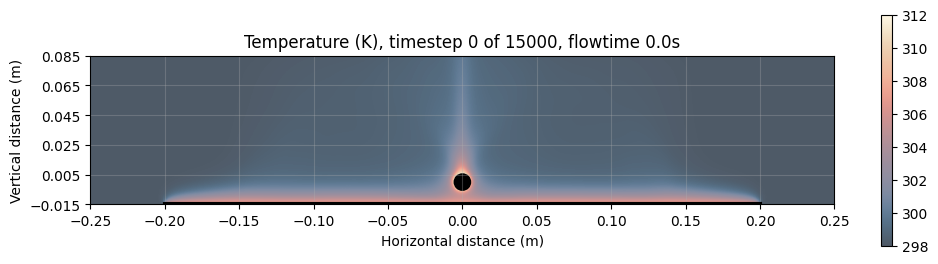

In [16]:
# Proof that they are mapped properly
fig, ax = plt.subplots(figsize=(12,3))
p_ = ax.imshow(SI, extent=[XMIN, XMAX, YMIN, YMAX], alpha=0.7, cmap=cm.lipari) #cmap='Greys')
ax.set_title("Temperature (K), timestep {} of {}, flowtime {}s".format(timestep, len(data_files), timestep*0.05*2))
print(SI.max())
plt.plot(np.arange(-0.2, 0.21, 0.01), np.ones((np.arange(-0.2, 0.21, 0.01).shape))*-0.015, color='k', linewidth=3)
plt.ylim([-0.015, 0.085])
plt.xlim([-0.25, 0.25])
plt.gca().set_aspect('equal')

# Manually set x ticks and labels
x_ticks = np.arange(-0.25, 0.26, 0.05)
x_labels = ['Zero', 'One', 'Two', 'Three']
ax.set_xticks(x_ticks)
# Manually set y ticks and labels
y_ticks = np.arange(-0.015, 0.086, 0.02)
y_labels = ['Zero', 'Three', 'Six', 'Nine']
ax.set_yticks(y_ticks)

circle = patches.Circle((0,0), radius=0.005, edgecolor='k', facecolor='k', linewidth=2)

plt.grid(alpha=0.3)
plt.xlabel("Horizontal distance (m)")
plt.ylabel("Vertical distance (m)")

# Add the circle to the axis
ax.add_patch(circle)

plt.colorbar(p_)

In [11]:
# Save the grid data to an HDF5 file
with h5py.File(data_folder+'average_temp.h5', 'w') as f:
    f.create_dataset('T', data=SI)
    f.create_dataset('node_x', data=xgrid)
    f.create_dataset('node_y', data=ygrid)

In [12]:
def get_Qavg(SI):

    Tw = 308
    Height = 0.015
    CylinderDiameter = 0.01
    HeightOverDiamter = Height/CylinderDiameter

    Yw = -HeightOverDiamter*CylinderDiameter

    # Define the combined condition for masking
    mask_condition = (ygrid < Yw/1.02) & (xgrid < 0.2) & (xgrid > -0.2)
    y_ = np.unique(ygrid[ygrid <= -0.0147] )
    x_ = np.unique(xgrid[(xgrid < 0.2) & (xgrid > -0.2)])

    # Apply the mask to SI
    SI_masked = np.copy(SI)
    SI_masked[~mask_condition] = np.nan

    Y_ = np.unique(ygrid[ygrid <= Yw/1.02] )
    Y1 = Y_[-1]
    Y2 = Y_[-2]
    Y3 = Y1**2
    Y4 = Y2**2
    K_ThermalConductivity = 0.02225
    dTdy = []

    left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
    right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]
    SI_slice = SI_masked[:, left_wall_ind:right_wall_ind]

    for c in range(SI_slice.shape[1]):
        T1 = SI_slice[-1, c]
        T2 = SI_slice[-2, c]
        dTdy_value = (T1 * Y4 - T2 * Y3 - Tw * (Y4 - Y3)) / (Y1 * Y4 - Y2 * Y3)
        dTdy.append(dTdy_value)
    Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)
    return Qavg


In [13]:
get_Qavg(SI) #in W/m^2 per post file.

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_69521/2766577445.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)


np.float64(-18.449391512552594)